In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
def default_params(**kwargs):
    p = {}
     
    ### connection strengths ###
    p['Jexc_exc'] = 0.2609 #[nA]
    p['Jpv_pv'] = 0.2609 #[nA]
    p['Jpv_exc'] = -0.0497 #[nA]
    p['Jexc_pv'] = -0.0497 #[nA]
    
    ### synaptic gating ### 
    p['tS'] = 0.1              # [s] Time scale of synaptic gating
    p['gamma'] = 0.641

    ### Stimulus Parameters ###
    p['Jaext'] = 5.2e-4        # [nA/Hz]
    p['mu0'] = 30              # [Hz]
    p['coh'] = 0.5
    p['Tstim'] = 1.    # Time of stimulus 1 onset [sec]
    p['Tdur'] = 2.     # Duration of stimulus 1 [sec]
    
    ### Noise ###
    p['sigma'] = 0.02
    p['tau0'] = 0.002

    ### simulation parameters ###
    p['T']         = 5. # Total duration of simulation [sec]
    p['dt']        = 0.001 # Simulation time step [sec]
    
    return p

FI curves

In [55]:
def F_exc(I, a=270., b=108., d=0.154):
    return (a*I - b + 1e-8)/(1. - np.exp(-d*(a*I - b + 1e-8)))

def F_pv(I, threshold=108/270, BetaPV=100):
    # PV neuron firing rate as a function of currrent I in [nA]
    return max(0, BetaPV*(I - threshold))

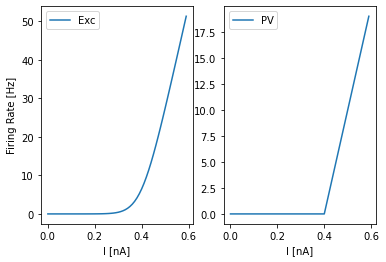

In [56]:
irange = np.arange(0, 0.6, 0.01)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(irange, F_exc(irange), label = 'Exc')
ax2.plot(irange, np.array([F_pv(i) for i in irange]), label = 'PV')
ax1.set(xlabel = 'I [nA]', ylabel = 'Firing Rate [Hz]')
ax2.set(xlabel = 'I [nA]')
ax1.legend()
ax2.legend()

In [59]:
class full_circuit_model:    
    def __init__(self, pars, extraParams=None):
        self.params = pars
        
        if extraParams:
            for key in extraParams:
                self.params[key] = extraParams[key]
    
    def run_sim(self, **kwargs):
        p = self.params
        
        results = {}
        
        # Stimulus current
        Istim_exc = p['Jaext']*p['mu0']*(1 + p['coh']/100)
        Istim_pv = p['Jaext']*p['mu0']*(1 - p['coh']/100)
        
        # Background current
        Ibg_exc = 0.3255 #[nA]
        Ibg_pv = 0.3255 #[nA]

        t_range = np.arange(0, p['T'], p['dt'])
        nsteps = t_range.size
        
        #initialize
        s_exc = 0.1*np.zeros(nsteps)
        s_pv = 0.1*np.zeros(nsteps)
        
        r_exc = np.zeros(nsteps)
        r_pv = np.zeros(nsteps)
        
        Inoise_exc = np.zeros(nsteps)
        Inoise_pv = np.zeros(nsteps)
                
        for t in range(nsteps - 1):
            
            # Total synaptic input
            Isyn_exc = p['Jexc_exc']*s_exc[t]  + p['Jpv_exc']*s_pv[t] + Istim_exc + Ibg_exc + Inoise_exc[t]
            Isyn_pv = p['Jpv_pv']*s_pv[t]  + p['Jexc_pv']*s_exc[t] + Istim_pv + Ibg_pv + Inoise_pv[t]
            
            # Transfer functions
            r_exc[t] = F_exc(Isyn_exc)
            r_pv[t] = F_exc(Isyn_pv)
            
            # forward euler integration for synaptic gating variables]
            s_pv[t+1] = s_pv[t] + p['dt']*(-s_pv[t]/p['tS'] + (1 - s_pv[t])*p['gamma']*r_pv[t])
            s_exc[t+1] = s_exc[t] + p['dt']*(-s_exc[t]/p['tS'] + (1 - s_exc[t])*p['gamma']*r_exc[t])
            
            # Noise 
            Inoise_exc[t+1] = Inoise_exc[t] + (p['dt']/p['tau0'])*(0.-Inoise_exc[t]) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*np.random.randn()
            Inoise_pv[t+1] = Inoise_pv[t] + (p['dt']/p['tau0'])*(0.-Inoise_pv[t]) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*np.random.randn()

        results = {
            'trange': t_range,
            'rexc': r_exc,
            'rpv': r_pv
        }
        
        return results

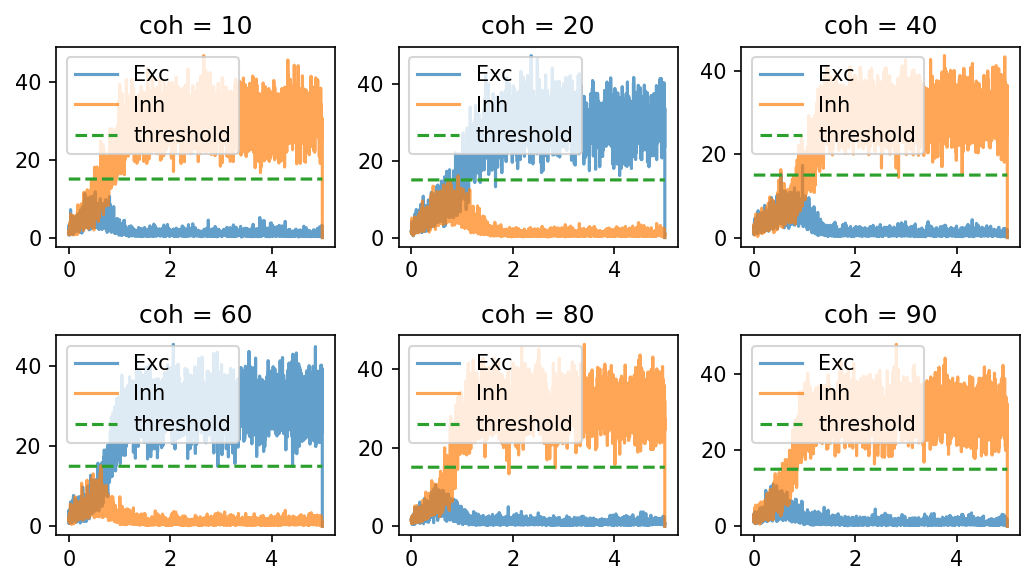

In [76]:
# plot for only PV and Exc
fig, axs = plt.subplots(2,3, figsize = (7,4), dpi = 150)

for i, coh in enumerate([10, 20, 40, 60, 80, 90]):
    ax = axs[int(i/3)][i%3]
    run1 = full_circuit_model(default_params(coh=20))
    res = run1.run_sim()

    ax.plot(res['trange'], res['rexc'], alpha = 0.7, label = 'Exc')
    ax.plot(res['trange'], res['rpv'], alpha = 0.7, label = 'Inh')
    ax.plot(res['trange'], np.ones(res['trange'].size)*15, '--', label = 'threshold')
    ax.set(title = 'coh = ' + str(coh))
    ax.legend()
fig.tight_layout()